In [2]:
from sklearn.preprocessing import MinMaxScaler
# preprocessing by mic
from sklearn.feature_selection import SelectKBest
import numpy as np
from minepy import MINE
import pandas as pd
import csv
import pymrmr

In [3]:
#########################################
from sklearn.ensemble import RandomForestClassifier
def rf_handler(X, Y, feature_names):
    clf=RandomForestClassifier(max_depth = 3, n_estimators=200, random_state=42)
    clf.fit(X, Y)
    importance = clf.feature_importances_.reshape(-1,1)  
    mm = MinMaxScaler()
    mm.fit(importance)
    result = list(zip(feature_names, importance.reshape(-1)))
    result.sort(key=lambda a:a[1], reverse=True)
    # 将结果转换为数据框
    top_features_df = pd.DataFrame(result[:num], columns=['Feature_name', 'Importance']).set_index('Feature_name')

    return top_features_df

###############################
from sklearn.linear_model import LinearRegression
def lr_handler(X, Y, feature_names):
    lr = LinearRegression()
    lr.fit(X,Y)
    importance = np.abs(lr.coef_).reshape(-1,1)
    mm = MinMaxScaler()
    mm.fit(importance)
    result = list(zip(feature_names, importance.reshape(-1)))
    result.sort(key=lambda a:a[1], reverse=True)
    top_features_df = pd.DataFrame(result[:num], columns=['Feature_name', 'Importance']).set_index('Feature_name')

    return top_features_df


from sklearn.linear_model import Lasso
def lasso_handler(X, Y, feature_names):
    '''
    select the best 50 features by Lasso

    return: selected features
    '''
    lasso = Lasso(alpha=.01)
    lasso.fit(X,Y)
    importance = np.abs(lasso.coef_).reshape(-1,1)
    mm = MinMaxScaler()
    mm.fit(importance)
    result = list(zip(feature_names, importance.reshape(-1)))
    result.sort(key=lambda a:a[1], reverse=True)
    top_features_df = pd.DataFrame(result[:num], columns=['Feature_name', 'Importance']).set_index('Feature_name')

    return top_features_df


from sklearn.linear_model import RidgeCV
def ridge_handler(X, Y, feature_names):
    '''
    select the best 50 features by Ridge

    return: selected features
    '''
    # 标准化数据
    loo = LeaveOneOut()
    # 岭回归模型，使用交叉验证确定正则化参数alpha
    ridge = RidgeCV(cv=loo)
    ridge.fit(X, Y)

   # 提取特征权重并排序

    importance = np.abs(ridge.coef_).reshape(-1,1)
    mm = MinMaxScaler()
    mm.fit(importance)
    result = list(zip(feature_names, importance.reshape(-1)))
    result.sort(key=lambda a:a[1], reverse=True)
    top_features_df = pd.DataFrame(result[:num], columns=['Feature_name', 'Importance']).set_index('Feature_name')

    return top_features_df

from sklearn.ensemble import ExtraTreesClassifier
def dt_handler(X, Y, feature_names):
    '''
    select the best 50 features by decision tree

    return: selected features
    '''
    np.random.seed(111)
    dt = ExtraTreesClassifier()
    dt.fit(X,Y)
    importance = np.abs(dt.feature_importances_).reshape(-1,1)
    mm = MinMaxScaler()
    mm.fit(importance)
    result = list(zip(feature_names, importance.reshape(-1)))
    result.sort(key=lambda a:a[1], reverse=True)
    top_features_df = pd.DataFrame(result[:num], columns=['Feature_name', 'Importance']).set_index('Feature_name')

    return top_features_df

def final_handler(X, Y, feature_names):
    result_rf = rf_handler(X, Y, feature_names)
    result_lasso = lasso_handler(X, Y, feature_names)
    result_ridge = ridge_handler(X, Y, feature_names)
    #result_stab = stab_handler(X, Y, feature_names)
    result_rfe = rfe_handler(X, Y, feature_names)
    result_dt = dt_handler(X, Y, feature_names)
    result_temp = result_rf+result_lasso+result_ridge+result_rfe+result_dt
    result = [x[0] for x in result_temp]
    result = pd.value_counts(result)
    result_final = list(zip(result.keys().tolist(),result.tolist()))
    return result_final

In [4]:
# get data
import pandas as pd
import datetime
from sklearn import preprocessing
data_file = 'N_H_ex.csv'
data = pd.read_csv(data_file, sep = ',')
X = pd.read_csv(data_file, sep = ',',index_col=0)
X=X.T
data_file = 'label_H_N.csv'
data = pd.read_csv(data_file, sep = ',')
data=data.set_index('Sample')
Y=data['label']
feature_names = X.columns

In [5]:
Y = data.iloc[:,0].values
Y = preprocessing.LabelEncoder().fit_transform(Y)
num =X.shape[1]


In [6]:
import numpy as np
from scipy.stats import ttest_ind
selected_indices = np.where(p_values <0.05)[0]
feature_names = list(X.columns)
selected_indices = np.where(p_values < 0.05)[0]

In [8]:
def mic(x, Y):
    mine = MINE()
    mine.compute_score(x,Y)
    return mine.mic()
selector = SelectKBest(lambda X,Y: np.array(list(map(lambda x: mic(x,Y),X.T))), k=num)
selector.fit_transform(X, Y)
selected_indices = selector.get_support(indices=True)
selected_features = [X.columns[index] for index in selected_indices]
contributions = [mic(X.iloc[:, index], Y) for index in selected_indices]
data = {"Feature": selected_features, "Contribution": contributions}
df = pd.DataFrame(data)

mic_df = df.sort_values(by="Contribution", ascending=False)
mic_column = mic_df.iloc[:, 0].reset_index(drop=True)


In [9]:
from sklearn.feature_selection import f_classif
f_values, p_values = f_classif(X, Y)
feature_tuples = [(X.columns[i], f_values[i], p_values[i]) for i in range(len(X.columns))]

ANOVA_df = pd.DataFrame(feature_tuples, columns=['Name', 'F_value', 'p_value']).sort_values(by='F_value', ascending=False)

ANOVA_mic_column = ANOVA_df['Name'].reset_index(drop=True)
ANOVA_column = ANOVA_df['Name'].tolist()

In [10]:
from sklearn.feature_selection import mutual_info_classif
mi_scores = mutual_info_classif(X, Y)
features_mi_scores = dict(zip(X.columns, mi_scores))
sorted_features = sorted(features_mi_scores.items(), key=lambda x: x[1], reverse=True)
MI_df = pd.DataFrame(sorted_features, columns=['Feature', 'MI Score'])
MI_column =MI_df.iloc[:, 0]

In [11]:
import numpy as np
from sklearn.datasets import make_classification
from skrebate import ReliefF
import random
import numpy as np
random.seed(123)
np.random.seed(123)

relieff = ReliefF()
X1 = X.to_numpy()

relieff.fit(X1, Y)

feature_scores = relieff.feature_importances_

feature_names = X.columns.tolist()

features_scores_dict = dict(zip(feature_names, feature_scores))

sorted_features = sorted(features_scores_dict.items(), key=lambda x: x[1], reverse=True)

ReliefF_df = pd.DataFrame(sorted_features, columns=['Feature', 'Score'])
ReliefF_column =ReliefF_df.iloc[:, 0]

In [14]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

random.seed(123)
np.random.seed(123)
model = GradientBoostingClassifier()  # or GradientBoostingRegressor()
model.fit(X, Y)
feature_importance = model.feature_importances_
features_importance_scores = dict(zip(X.columns, feature_importance))
sorted_features = sorted(features_importance_scores.items(), key=lambda x: x[1], reverse=True)
Boost_df = pd.DataFrame(sorted_features, columns=['Feature', 'Importance_score'])
Boost_column =Boost_df.iloc[:, 0]

In [15]:
RF_result = rf_handler(X, Y, feature_names)
RF_column =RF_result.index.tolist()

In [16]:
LR_result = lr_handler(X, Y, feature_names)
LR_column = LR_result.index.tolist()

In [17]:
lasso_result = lasso_handler(X, Y, feature_names)
lasso_column =lasso_result.index.tolist()

In [18]:
# select features by ridge
ridge_result = ridge_handler(X, Y, feature_names)
ridge_column =ridge_result.index.tolist()

In [19]:
DT_result = dt_handler(X, Y, feature_names)
DT_column = DT_result.index.tolist()

In [20]:
df_all = pd.DataFrame({'mic_column': mic_column, 'ANOVA_column': ANOVA_column,'MI_column':MI_column,'ReliefF_column':ReliefF_column,'Boost_column':Boost_column,
                   'RF_column':RF_column,'LR_column':LR_column,'lasso_column':lasso_column,'ridge_column':ridge_column,'DT_column':DT_column })


In [21]:
df_all.to_csv('RRA_2024.csv', index=False)

In [22]:
data_file = 'star_rra.csv'
data_rra = pd.read_csv(data_file, sep = ',', index_col=0)


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, LeaveOneOut

def Fitness(X, y):
    #model = SVC(probability=True)
    model = RandomForestClassifier(max_depth=3, n_estimators=100, random_state=42)
    loo = LeaveOneOut()
    fitness = cross_val_score(model, X, y, cv=loo, scoring='accuracy')
    #return np.mean(fitness)

In [59]:
df_sorted=X

In [60]:
#mic_column,ANOVA_column,MI_column,ReliefF_column,Boost_column,RF_column,LR_column,lasso_column,ridge_column,DT_column
###MI_column、Boost_column、RF_column
df_sorted = X[MI_column]

In [80]:
from sklearn.tree import DecisionTreeClassifier 
model4 = DecisionTreeClassifier(max_depth=6, random_state=123)


In [75]:
bestFes=df_sorted.iloc[:, :10]

In [64]:
y=Y

In [81]:
loo = LeaveOneOut()
y_scores4 = cross_val_predict(model4, bestFes, y, cv=loo, method='predict_proba')

fpr4, tpr4, thresholds4 = roc_curve(y, y_scores4[:, 1])
roc_auc4 = auc(fpr4, tpr4)


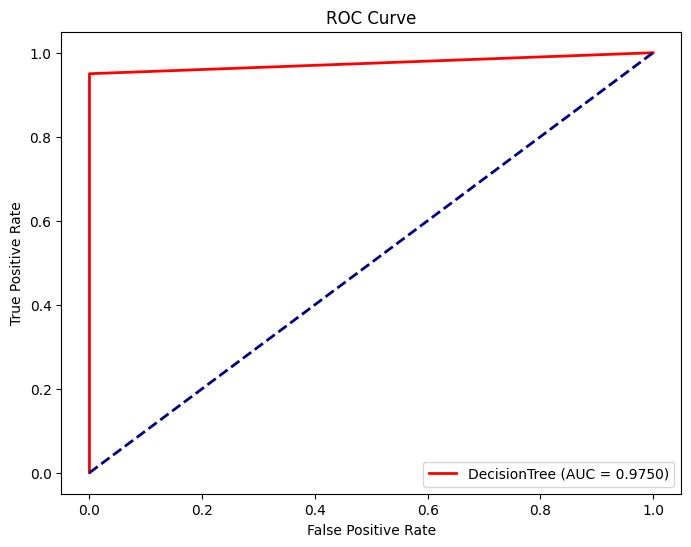

In [85]:
# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))

lw = 2

#plt.plot(fpr1, tpr1, color='darkorange', lw=lw, label='RandomForest (AUC = %0.4f)' % roc_auc1)
#plt.plot(fpr2, tpr2, color='blue', lw=lw, label='SVM (AUC = %0.4f)' % roc_auc2)
plt.plot(fpr4, tpr4, color='red', lw=lw, label='DecisionTree (AUC = %0.4f)' % roc_auc4)
#plt.plot(fpr6, tpr6, color='purple', lw=lw, label='LogisticRegression (AUC = %0.4f)' % roc_auc6)

#plt.plot(fpr3, tpr3, color='green', lw=lw, label='KNeighbors (AUC = %0.4f)' % roc_auc3)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()